# AI in Industry project
# Flare prediction
- Ildebrando Simeoni - ildebrando.simeoni@studio.unibo.it
- Davide Femia - davide.femia@studio.unibo.it
- Riccardo Falco - riccardo.falco2@tudio.unibo.it
- Vincenzo Collura - vincenzo.collura2@studio.unibo.it


## Libraries

In [ ]:
# TO DO: aggiungere tutte le librerie utili anche per LSTM e CNN

In [ ]:
%load_ext autoreload
%autoreload 2
from Libs.load_data import DataLoader
import Libs.flares_plot as fplt
from Libs.threshold import get_labels_physic
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

## Dataframe building

In [ ]:
# TO DO: sostituire tutte le seguenti celle con la funzione di Davide per creare il dataframe con cui traineremo tutti i modelli

### Da sostituire

In [ ]:
# initialize data loader
data_loader = DataLoader()
# get the grid
grid = data_loader.get_grid()
# get params dictionary
params = data_loader.get_params()

params

{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'mu': [0.8, 0.9, 1, 1.1],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

In [ ]:
print(grid.shape)

(30, 4, 4, 4, 10, 1000)


In [ ]:
run, mu, sigma, theta, delta = 0, 1, 0.5, 3, 0.2

In [ ]:
# get labels following physics method
physic_labels = get_labels_physic(grid, params, alpha=2)


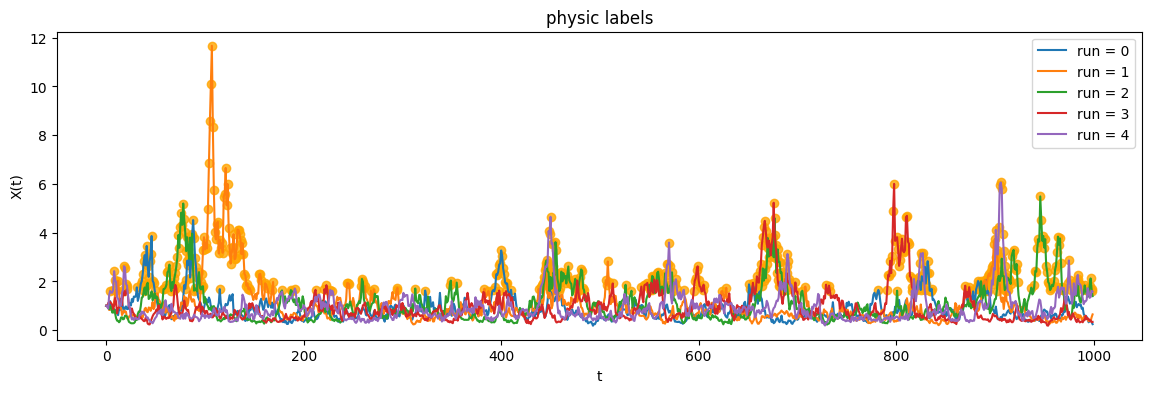

In [ ]:
run, mu, sigma, theta, delta = 1, 1, 0.3, 0.1, 0.5
# focuses on specific runs
#fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, labels=labels)
# focuses on a set of runs
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=physic_labels, title='physic labels')

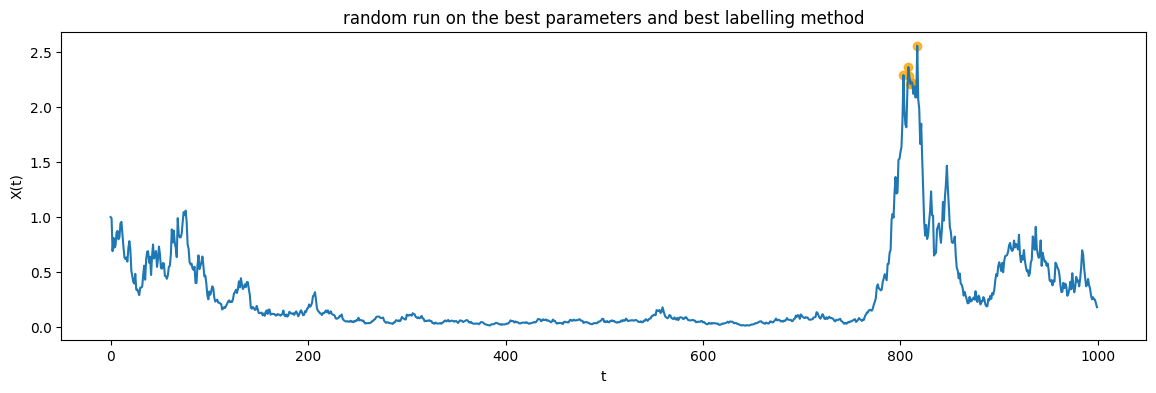

In [ ]:
# # extract the standard values
run = 6
labels_best = physic_labels
# labels_best = kde_labels
# labels_best = quantile_labels
bindexes = data_loader.get_standard_indexes()
X_best = data_loader.get_standard_values(run=run)
best_labels = labels_best[run, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

# # plot one single light curve
fplt.plot_serie(X_best, labels=best_labels, title='random run on the best parameters and best labelling method')

In [ ]:
best_Xs = grid[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
best_labels = labels_best[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

window_size = 10
overlap_size = 0
label_treshold = 1
stride = window_size - overlap_size
num_windows = (best_Xs.shape[-1]-window_size)//stride + 1

windows = np.zeros((best_Xs.shape[0]*(num_windows-1),window_size))
windows_label = np.zeros((best_labels.shape[0]*(num_windows-1),window_size), dtype='bool')


for i in range(best_Xs.shape[0]):
    tmp_windows = np.array([best_Xs[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    tmp_windows_labels = np.array([best_labels[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    windows[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows[:-1,:]
    windows_label[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows_labels[1:,:]

windows_label = np.sum(windows_label, axis=-1)
windows_label[windows_label<label_treshold] = 0
windows_label[windows_label>=label_treshold] = 1

windows_df = pd.DataFrame(windows, columns=[f't_{i}' for i in range(windows.shape[-1])])
label_df = pd.DataFrame({'future_flare':windows_label})
labelled_windows_df = pd.concat([windows_df, label_df], axis=1)

labelled_windows_df



,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,future_flare
0,1.000000,0.987600,0.785896,0.841577,0.832249,0.782339,1.098576,1.034369,1.065688,1.396328,0
1,1.344950,1.361417,1.454124,1.481221,1.739084,1.824354,1.865991,1.748245,2.016654,1.962600,0
2,2.136767,1.900910,1.842975,1.392468,0.936490,1.009156,1.114423,1.093375,1.016034,1.035544,0
3,1.111971,1.152431,0.897187,0.842220,1.124429,1.031089,1.097192,1.374208,1.586394,1.373240,0
4,1.148019,1.039919,1.102339,1.152287,1.061448,0.908979,0.846604,0.678237,0.596491,0.666381,0
...,...,...,...,...,...,...,...,...,...,...,...
2965,0.087812,0.062624,0.065280,0.052309,0.048366,0.055236,0.058978,0.063442,0.058054,0.055112,0
2966,0.057390,0.063970,0.063839,0.053189,0.038101,0.037498,0.047341,0.045256,0.053053,0.052463,0
2967,0.056596,0.056859,0.059152,0.059293,0.060328,0.054363,0.052793,0.051796,0.059634,0.063387,0
2968,0.065167,0.055373,0.063792,0.072816,0.072152,0.065053,0.057493,0.055421,0.058620,0.050251,0


In [ ]:
labelled_windows_df['future_flare'].value_counts()

0    2782
1     188
Name: future_flare, dtype: int64

In [ ]:
test_size = 0.3
random_state = 42

X = labelled_windows_df.iloc[:,:-1].to_numpy()
y = labelled_windows_df.future_flare.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
class_weights = {0: 1, 1: 5}


## Models

### Simple models

In [ ]:
class_weights = {0: 1, 1: 5}

In [ ]:
# TO DO: valutare se spostare queste funzioni nella libreria, e se tenere solo alcuni di questi modelli (i.e. quelli le cui predizioni probabilistiche non sono 1/0)

In [ ]:
def train_classifier(X_train, y_train, class_weights):

    model_svc = SVC(class_weight= class_weights, probability=True).fit(X_train, y_train)
    model_rf = RandomForestClassifier(class_weight= class_weights).fit(X_train, y_train)
    model_nb = GaussianNB().fit(X_train, y_train)
    model_lr = LogisticRegression(class_weight= class_weights).fit(X_train, y_train)
    model_knn = KNeighborsClassifier().fit(X_train, y_train)

    return model_svc, model_rf, model_nb, model_lr, model_knn

In [ ]:
def test_predictions(model_svc, model_rf, model_nb, model_lr, model_knn):

    y_pred_svc = model_svc.predict(X_test)
    y_pred_rf = model_rf.predict(X_test)
    y_pred_nb = model_nb.predict(X_test)
    y_pred_lr = model_lr.predict(X_test)
    y_pred_knn = model_knn.predict(X_test)

    return y_pred_svc, y_pred_rf, y_pred_nb, y_pred_lr, y_pred_knn

In [ ]:
def print_classification_reports(y_test, y_pred_svc, y_pred_rf, y_pred_nb, y_pred_lr, y_pred_knn):
    
    print("classification reports:\n")
    print("SVC\n\n")
    print(classification_report(y_test, y_pred_svc))
    report_svc = classification_report(y_test, y_pred_svc, output_dict=True)
    print("\nRANDOM FOREST\n\n")
    print(classification_report(y_test, y_pred_rf))
    report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
    print("\nNAIVE BAYES\n\n")
    print(classification_report(y_test, y_pred_nb))
    report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
    print("\nLOGISTIC REGRESSION\n\n")
    print(classification_report(y_test, y_pred_lr))
    report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
    print("\nKNN\n\n")
    print(classification_report(y_test, y_pred_knn))
    report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

    return report_svc, report_rf, report_nb, report_lr, report_knn

In [ ]:
def print_confusion_matrices(y_test, y_pred_svc, y_pred_rf, y_pred_nb, y_pred_lr, y_pred_knn):
    
    cm = []

    print("classification reports:\n")
    print("SVC\n\n")
    print(confusion_matrix(y_test, y_pred_svc))
    cm.append(confusion_matrix(y_test, y_pred_svc))
    print("\nRANDOM FOREST\n\n")
    print(confusion_matrix(y_test, y_pred_rf))
    cm.append(confusion_matrix(y_test, y_pred_rf))
    print("\nNAIVE BAYES\n\n")
    print(confusion_matrix(y_test, y_pred_nb))
    cm.append(confusion_matrix(y_test, y_pred_nb))
    print("\nLOGISTIC REGRESSION\n\n")
    print(confusion_matrix(y_test, y_pred_lr))
    cm.append(confusion_matrix(y_test, y_pred_lr))
    print("\nKNN\n\n")
    print(confusion_matrix(y_test, y_pred_knn))
    cm.append(confusion_matrix(y_test, y_pred_knn))

    return cm

In [ ]:
model_svc, model_rf, model_nb, model_lr, model_knn = train_classifier(X_train, y_train, class_weights)
print("Probability prediction examples:\n")
print("SVC\n\n")
print(model_svc.predict_proba(X_test))
print("\nRANDOM FOREST\n\n")
print(model_rf.predict_proba(X_test))
print("\nNAIVE BAYES\n\n")
print(model_nb.predict_proba(X_test))
print("\nLOGISTIC REGRESSION\n\n")
print(model_lr.predict_proba(X_test))
print("\nKNN\n\n")
print(model_knn.predict_proba(X_test))

In [ ]:
y_pred_svc, y_pred_rf, y_pred_nb, y_pred_lr, y_pred_knn = test_predictions(model_svc, model_rf, model_nb, model_lr, model_knn)

In [ ]:
report_svc, report_rf, report_nb, report_lr, report_knn = print_classification_reports(y_test, y_pred_svc, y_pred_rf, y_pred_nb, y_pred_lr, y_pred_knn)

classification reports:

SVC


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       835
           1       0.86      0.89      0.88        56

    accuracy                           0.98       891
   macro avg       0.93      0.94      0.93       891
weighted avg       0.98      0.98      0.98       891


RANDOM FOREST


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       835
           1       0.95      0.62      0.75        56

    accuracy                           0.97       891
   macro avg       0.96      0.81      0.87       891
weighted avg       0.97      0.97      0.97       891


NAIVE BAYES


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       835
           1       0.74      0.89      0.81        56

    accuracy                           0.97       891
   macro avg       0.86      0.94      0.90       891
weighted av

In [ ]:
cm = print_confusion_matrices(y_test, y_pred_svc, y_pred_rf, y_pred_nb, y_pred_lr, y_pred_knn)

classification reports:

SVC


[[827   8]
 [  6  50]]

RANDOM FOREST


[[833   2]
 [ 21  35]]

NAIVE BAYES


[[817  18]
 [  6  50]]

LOGISTIC REGRESSION


[[831   4]
 [ 13  43]]

KNN


[[831   4]
 [ 14  42]]


### LSTM

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.initializers import Constant
from itertools import product
from tqdm import tqdm


from Libs.load_data import ClassificationDataLoader, DataLoader, get_dataset_split
from Libs.threshold import get_labels_physic
from Libs.keras_f1score import f1_m

2023-03-11 16:38:40.776540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 16:38:41.470247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 16:38:41.470340: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 16:38:44.698281: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

For this test we attempted the following configuration
```
{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}
```

In [ ]:
data_loader = ClassificationDataLoader(run=100, N=1000, s=0.5, t=0.01, d=0.2, m=1)
params = data_loader.get_params()
params

{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}

In [ ]:
Xs, best_labels = data_loader.load_data(override=True)

Loading Data


100%|██████████| 100/100 [00:00<00:00, 322.71it/s]

Loading Labels
Labels Loaded


In [ ]:
bindexes = data_loader.get_standard_indexes()
df_train,df_val,df_test = get_dataset_split(Xs, best_labels, bindexes, window_size=20, overlap_size=19,
                                            label_treshold=1, split_on_run=True, shuffle_run=False, 
                                            shuffle_window=False, test_size = 0.3, val_size=0.2, 
                                            get_validation=True, random_state=42)

In [ ]:
# number of classes
print('Training set:')
print(df_train['future_flare'].value_counts(), '\n')
pos = df_train['future_flare'].value_counts()[0]
true = df_train['future_flare'].value_counts()[1]
print('validation set:')
print(df_val['future_flare'].value_counts(), '\n')
print('Test set:')
print(df_test['future_flare'].value_counts(), '\n')

Training set:
0    43768
1     4252
Name: future_flare, dtype: int64 

validation set:
0    18233
1     2347
Name: future_flare, dtype: int64 

Test set:
0    26357
1     3043
Name: future_flare, dtype: int64 



In [ ]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X = np.vstack((X_train, X_val, X_test))
y = np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('y ## Train:', y_train.shape, 'Val:', y_val.shape, 'Test:', y_test.shape)

X ## Train: (48020, 20) Val: (20580, 20) Test: (29400, 20)
y ## Train: (48020,) Val: (20580,) Test: (29400,)


In [ ]:
initial_bias = Constant([np.log(true/pos)])
# define model
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=(X_train.shape[1], 1)))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid',bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(model.summary())

2023-03-11 16:40:53.192431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-11 16:40:53.192637: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 16:40:53.192689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (83dc2cdd3c94): /proc/driver/nvidia/version does not exist
2023-03-11 16:40:53.193367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40)               3520      
 l)                                                              
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 20
batch_size = 32
# define callbacks
callbacks = [
    ModelCheckpoint(
        os.path.join("models", "LSTM_best_weights.h5"), save_weights_only=True, monitor="val_loss"
    ),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]
# fit model
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1501/1501 [==============================] - 37s 22ms/step - loss: 0.0517 - f1_m: 0.8051 - accuracy: 0.9811 - val_loss: 0.0219 - val_f1_m: 0.1485 - val_accuracy: 0.9926
Epoch 2/20
1501/1501 [==============================] - 48s 32ms/step - loss: 0.0277 - f1_m: 0.8642 - accuracy: 0.9883 - val_loss: 0.0182 - val_f1_m: 0.1450 - val_accuracy: 0.9934
Epoch 3/20
1501/1501 [==============================] - 44s 29ms/step - loss: 0.0254 - f1_m: 0.8643 - accuracy: 0.9893 - val_loss: 0.0196 - val_f1_m: 0.1477 - val_accuracy: 0.9926
Epoch 4/20
1501/1501 [==============================] - 41s 28ms/step - loss: 0.0240 - f1_m: 0.8847 - accuracy: 0.9900 - val_loss: 0.0211 - val_f1_m: 0.1450 - val_accuracy: 0.9917
Epoch 5/20
1501/1501 [==============================] - 37s 25ms/step - loss: 0

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.round(model.predict(X_test), 0)

print("### Evaluation on test set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_test)))
print("F1 score: %.2f" % (f1_score(y_pred, y_test)))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_pred)
print(result)


919/919 [==============================] - 8s 9ms/step
### Evaluation on test set ###
Accuracy: 1.00
F1 score: 0.99
[[26313    44]
 [   45  2998]]


In [ ]:
scores = model.evaluate(X_val, y_val, verbose=0)
y_pred = np.round(model.predict(X_val), 0)

print("### Evaluation on validation set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_val)))
print("F1 score: %.2f" % (f1_score(y_pred, y_val)))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred)
print(result)


644/644 [==============================] - 5s 8ms/step
### Evaluation on validation set ###
Accuracy: 1.00
F1 score: 0.99
[[18206    27]
 [   25  2322]]


### CNN

## Extra

### Model comparison

In [ ]:
# TO DO: eventuale confronto finale tra i migliori modelli ?

In [ ]:
models = ['SVC', 'RF', 'NB', 'LR', 'KNN']

fig = go.Figure([go.Bar(x=models, y=[report_svc['macro avg']['f1-score'], report_rf['macro avg']['f1-score'], report_nb['macro avg']['f1-score'], report_lr['macro avg']['f1-score'], report_knn['macro avg']['f1-score']])])
fig.update_layout(title_text='F!-macro for each model')
fig.show()

In [ ]:
rows, cols = 3, 2

fig = make_subplots(rows=rows, cols=cols)

index = 0

for i in range(rows):
    for j in range(cols):
        
        if index == 5: break

        m = [[cm[index][0][0], cm[index][0][1]], [cm[index][1][0], cm[index][1][1]]]

        fig.append_trace(go.Heatmap(z=m), row=i+1, col=j+1)

        index += 1


fig.update_layout(height=800, width=1000,title_text="Confusion matrices")
fig.show()

### Intrapolation vs Extrapolation

In [ ]:
# TO DO: inserire codice Ricc e spiegare differenza tra intrapolation ed extrapolation e perché con una migliorano i risultati